In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, model_from_json
import os
import shutil
import random


In [3]:
train_dir = r'C:\Users\MK Jutt\Desktop\MSc Data\My Exercises\Semester 2 CA1 DA&BDP\X-ray labelled\train'
validation_dir = r'C:\Users\MK Jutt\Desktop\MSc Data\My Exercises\Semester 2 CA1 DA&BDP\X-ray labelled\val'
test_dir = r'C:\Users\MK Jutt\Desktop\MSc Data\My Exercises\Semester 2 CA1 DA&BDP\X-ray labelled\test'
num_classes = len(os.listdir(train_dir))

# To Splitted into sub-folder 1000 random images but decrease the accuracy

In [4]:
# original_train_dir = r'C:\Users\MK Jutt\Desktop\MSc Data\My Exercises\Semester 2 CA1 DA&BDP\X-ray labelled\train'
# selected_train_dir = r'C:\Users\MK Jutt\Desktop\MSc Data\My Exercises\Semester 2 CA1 DA&BDP\X-ray labelled\selected_train'

# for class_name in os.listdir(original_train_dir):
#     os.makedirs(os.path.join(selected_train_dir, class_name), exist_ok=True)

# num_images_to_select = 1000

# for class_name in os.listdir(original_train_dir):
#     class_dir = os.path.join(original_train_dir, class_name)
#     selected_class_dir = os.path.join(selected_train_dir, class_name)
#     images = os.listdir(class_dir)
#     random.shuffle(images)
#     selected_images = images[:num_images_to_select]
#     for image in selected_images:
#         source_path = os.path.join(class_dir, image)
#         destination_path = os.path.join(selected_class_dir, image)
#         shutil.copy(source_path, destination_path)


# Getting images from folders and sub-folders

In [5]:
image_height, image_width = (224, 224)  # Adjust as needed
batch_size = 32                    # Increase the batch size will increase the GPU memorys
#validation_batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',  # Change to 'binary' for binary classification
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',  # Change to 'binary' for binary classification
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',  # Change to 'binary' for binary classification
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# CNN Modeling

In [6]:
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(image_height, image_width, 3)
)

# Add your custom classification layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [11]:
model.add(tf.keras.layers.Dropout(0.5))

# Optimization

In [12]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Early Stopping

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Applying the Convolutional layers

In [14]:
# Define your model architecture
model = tf.keras.Sequential([
    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    MaxPooling2D((2, 2)),

    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Convolutional layer 3 (optional)
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the feature maps
    Flatten(),

    # Fully connected layer 1
    Dense(128, activation='relu'),

    # Dropout layer to reduce overfitting (optional)
    Dropout(0.5),

    # Output layer for classification
    Dense(num_classes, activation='softmax')
])

# Compile your model with an optimizer and a loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # You can adjust the learning rate
loss = 'categorical_crossentropy'  # Use the appropriate loss function for your problem

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Now you can train or evaluate your model


In [15]:
print(f"Number of training batches: {len(train_generator)}")
print(f"Number of validation batches: {len(validation_generator)}")

Number of training batches: 163
Number of validation batches: 4


# Model Fitted and checked with different epoch

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,  # Adjust as needed 10, 30 and 60
    callbacks=[early_stopping]
)

Epoch 1/10
163/163 [==============================] - 389s 2s/step - loss: 0.4515 - accuracy: 0.8004 - val_loss: 0.3370 - val_accuracy: 0.9375
Epoch 2/10
163/163 [==============================] - 352s 2s/step - loss: 0.3289 - accuracy: 0.8524 - val_loss: 0.5065 - val_accuracy: 0.7604
Epoch 3/10
163/163 [==============================] - 376s 2s/step - loss: 0.3040 - accuracy: 0.8614 - val_loss: 0.2923 - val_accuracy: 0.9062
Epoch 4/10
163/163 [==============================] - 385s 2s/step - loss: 0.2849 - accuracy: 0.8773 - val_loss: 0.2296 - val_accuracy: 0.9167
Epoch 5/10
163/163 [==============================] - 412s 3s/step - loss: 0.2583 - accuracy: 0.8869 - val_loss: 0.2521 - val_accuracy: 0.8958
Epoch 6/10
163/163 [==============================] - 373s 2s/step - loss: 0.2517 - accuracy: 0.8903 - val_loss: 0.2289 - val_accuracy: 0.8958
Epoch 7/10
163/163 [==============================] - 356s 2s/step - loss: 0.2399 - accuracy: 0.9030 - val_loss: 0.2069 - val_accuracy: 0.9479

In [29]:
model.save("model.h5")

In [13]:
model.load_weights("model.h5")

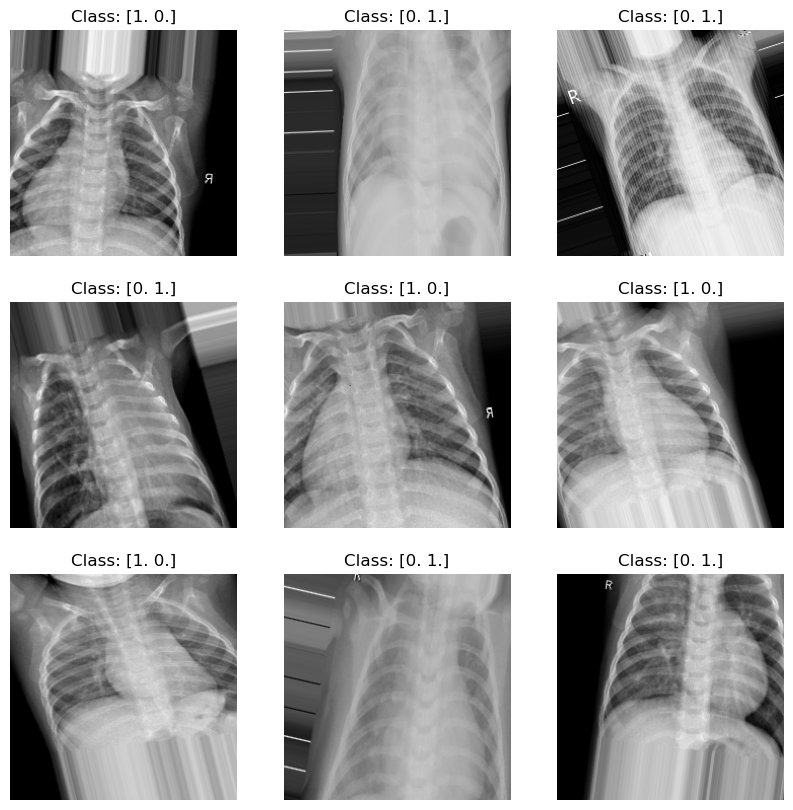

In [18]:
# Plot sample images from the training dataset
sample_images, sample_labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f'Class: {sample_labels[i]}')
    plt.axis('off')
plt.show()

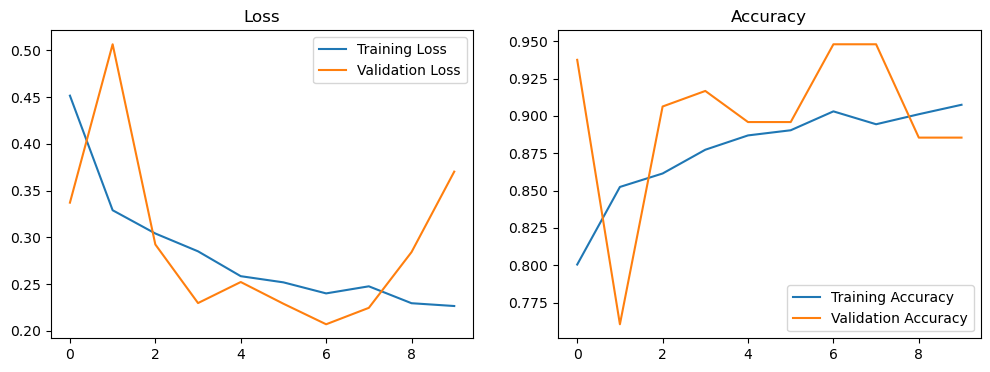

In [21]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

20/20 [==============================] - 20s 976ms/step


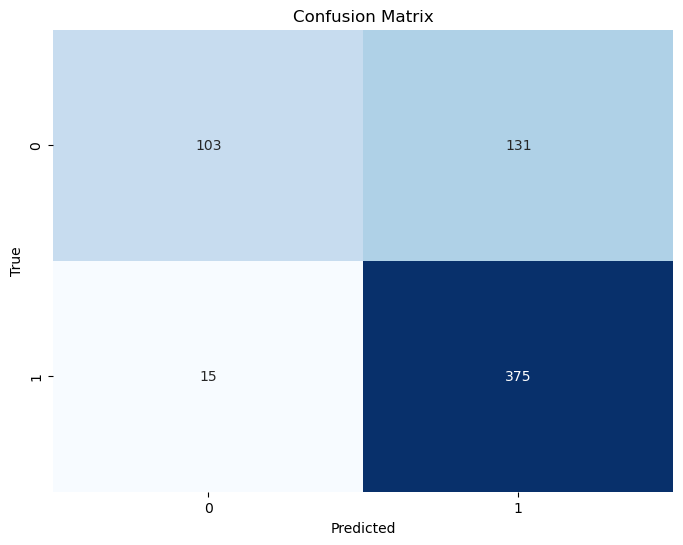

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Generate predictions from your model
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


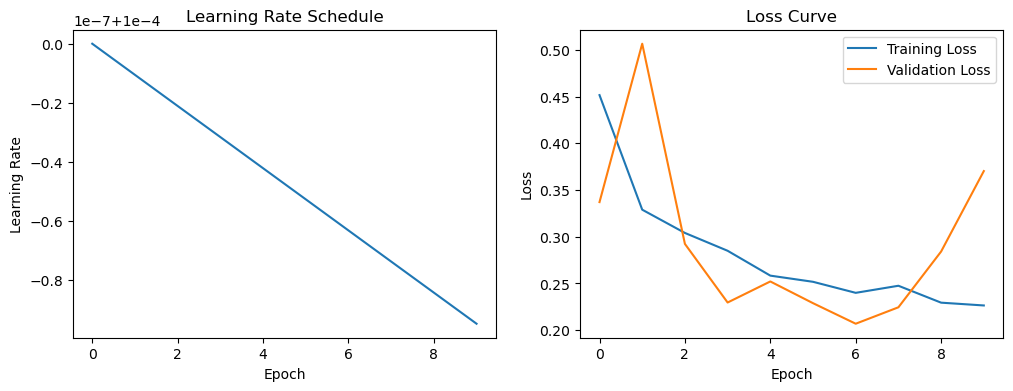

In [23]:
epochs = len(history.history['loss'])
lr = lr_schedule(tf.range(epochs))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), lr, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()


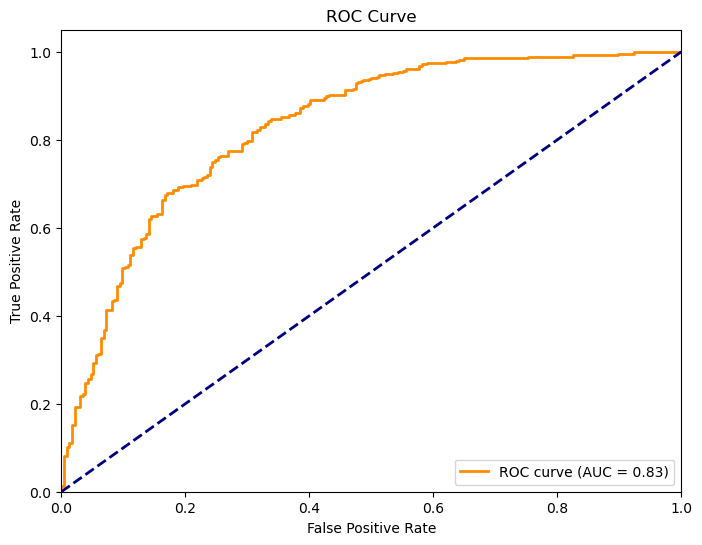

In [24]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, predictions[:, 1])
roc_auc = roc_auc_score(y_true, predictions[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 0s 79ms/step


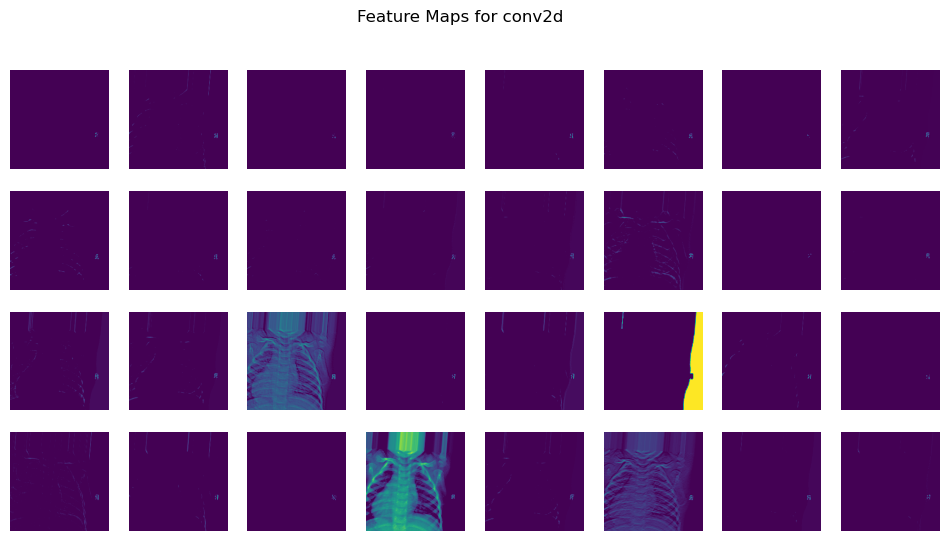

In [25]:
layer_name = 'conv2d'  # Replace with the layer name you want to visualize
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(sample_images[0:1])

plt.figure(figsize=(12, 6))
for i in range(intermediate_output.shape[-1]):
    plt.subplot(4, 8, i + 1)
    plt.imshow(intermediate_output[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle(f'Feature Maps for {layer_name}')
plt.show()


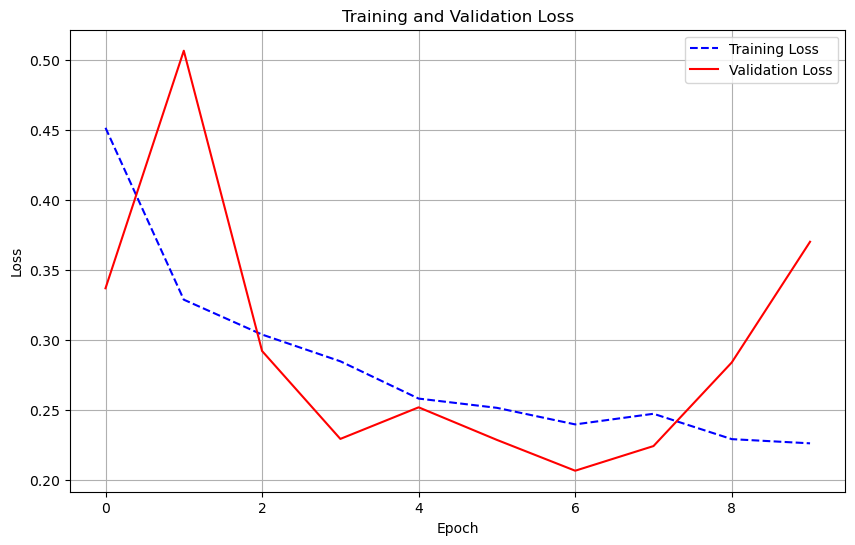

In [26]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# Predicted the 10 samples for Pneumonia

20/20 [==============================] - 11s 538ms/step
Number of images predicted as Pneumonia: 624
Predicted: Pneumonia
True: Pneumonia


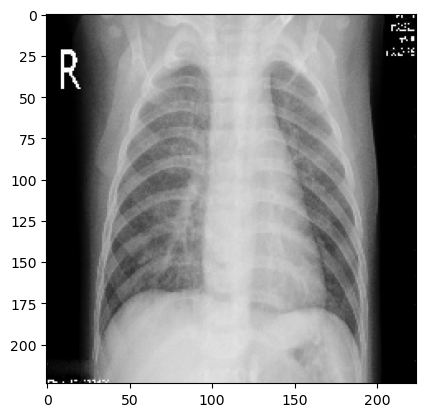

Predicted: Pneumonia
True: Pneumonia


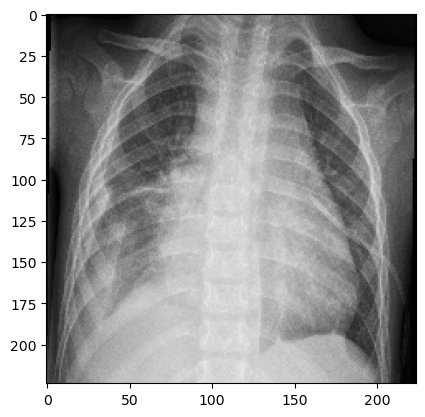

Predicted: Pneumonia
True: Pneumonia


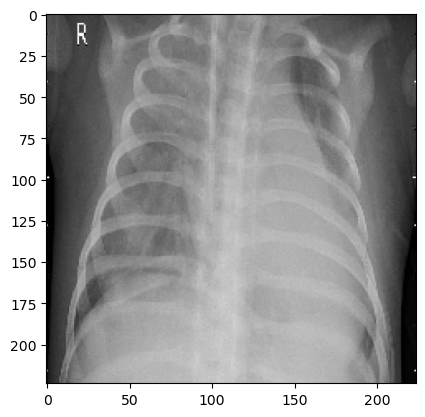

Predicted: Pneumonia
True: Pneumonia


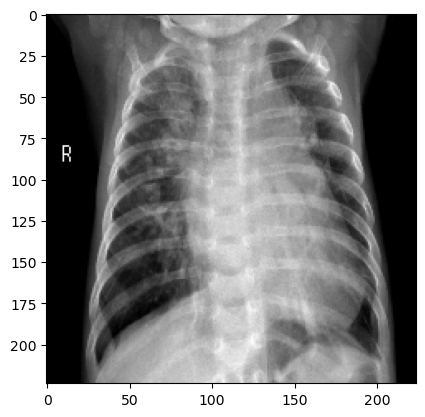

Predicted: Pneumonia
True: Pneumonia


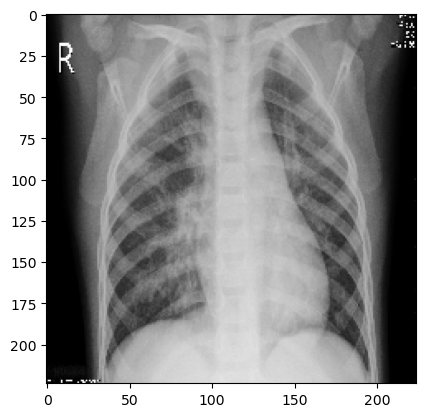

Predicted: Pneumonia
True: Pneumonia


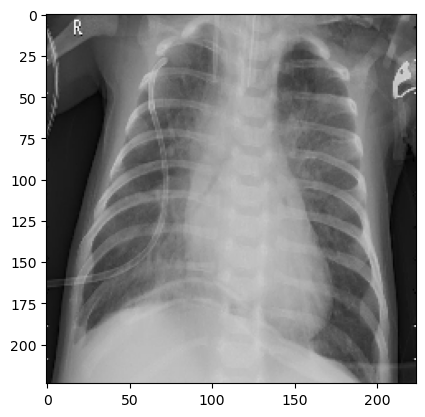

Predicted: Pneumonia
True: Pneumonia


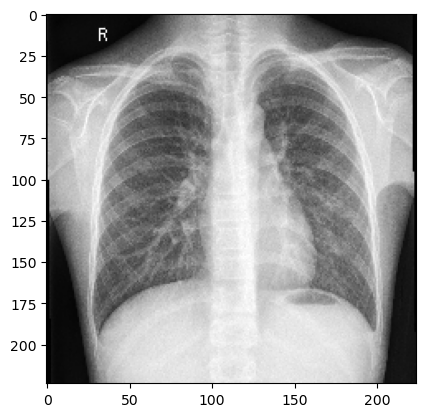

Predicted: Pneumonia
True: Pneumonia


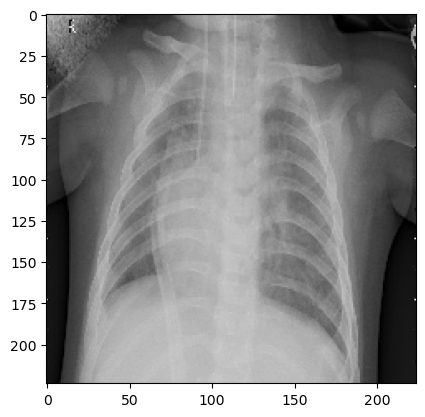

Predicted: Pneumonia
True: Pneumonia


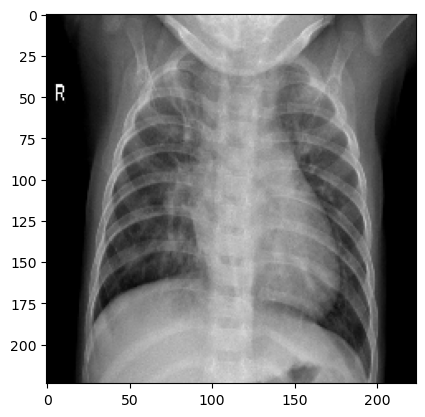

Predicted: Pneumonia
True: Pneumonia


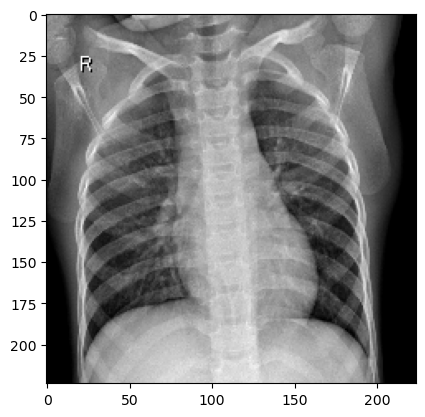

In [27]:
# Assuming you have trained your model and you have a test generator
test_predictions = model.predict(test_generator)

# Apply a threshold to predictions (e.g., 0.5)
threshold = 0.5
pneumonia_predictions = (test_predictions >= threshold).astype(int)

# Count how many images are predicted as pneumonia
num_pneumonia_cases = np.sum(pneumonia_predictions)
print(f"Number of images predicted as Pneumonia: {num_pneumonia_cases}")

# Inspect random test samples and their predictions
num_samples_to_inspect = 10  # Adjust as needed
random_indices = random.sample(range(len(test_generator)), num_samples_to_inspect)

for idx in random_indices:
    img, true_label = test_generator[idx]
    predicted_label = pneumonia_predictions[idx]

    if np.any(predicted_label == 1):
        print("Predicted: Pneumonia")
    else:
        print("Predicted: Non-Pneumonia")

    if np.any(true_label[0] == 1):
        print("True: Pneumonia")
    else:
        print("True: Non-Pneumonia")

    plt.imshow(img[0])
    plt.show()


# Below Code is to check the size of the image

In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Define the path to a sample image from your dataset
sample_image_path = r'C:\Users\MK Jutt\Desktop\MSc Data\My Exercises\Semester 2 CA1 DA&BDP\X-ray labelled\train\PNEUMONIA\person13_bacteria_49.jpeg'  # Replace with the actual path

# Load the sample image
img = image.load_img(sample_image_path, target_size=(image_height, image_width))
img_array = image.img_to_array(img)

# Verify the dimensions and data type of the image
print(f"Image shape: {img_array.shape}")
print(f"Image data type: {img_array.dtype}")

# Verify the pixel values (min, max)
min_pixel_value = np.min(img_array)
max_pixel_value = np.max(img_array)
print(f"Min pixel value: {min_pixel_value}")
print(f"Max pixel value: {max_pixel_value}")

# # Check if pixel values are within the expected range (0-1 or -1 to 1)

# if (min_pixel_value >= 0 and max_pixel_value <= 1) or (min_pixel_value >= -1 and max_pixel_value <= 1):
#     print("Pixel values are within the expected range.")
# else:
#     print("Pixel values are outside the expected range.")


Image shape: (224, 224, 3)
Image data type: float32
Min pixel value: 0.0
Max pixel value: 255.0
